<font style="font-size:40px">Statistics I</font>

---

In this session we will go through a high-level summary of some of the statistical techniques that we commonly need in data science. As per precedent, the main focus shall be on how to use specific Python packages related to statistics.

Main packages: __numpy__, __scipy__, __pandas__, __matplotlib__, __seaborn__.

_Many thanks to the creators of previous training sessions, whose code I have liberally "borrowed" from._

# Main content.

#### [Summary statistics](#h1_summary_stats)
#### [Testing for normality](#h1_normality)
#### [Measures of correlation](#h1_correlation)
#### [Regression](#h1_regression)
#### [Resampling](#h1_resampling)
#### [Optimisation](#h1_optimisation)
#### [Sampling from random distributions](#h1_rand_samp)
#### [Standard deviation](#h1_std_dev)
#### [Director's cut](#h1_directors_cut)

# Instructions.

1. Run the single cell below. This will install a slightly newer versions of pandas and seaborn than the versions that come pre-installed. We want the new versions for certain features and bug fixes.
1. __Kernel > Restart Kernel and Run All Cells__. This will take a minute or two.
1. Scroll to "Load data sets".

In [1]:
# When you first open the Notebook, run this cell once to update pandas, then restart the kernel for the update to take effect.
# (We need a specific feature of pandas that was introduced in v. 0.25.0. Likewise seaborn 0.9.0.)

from IPython.display import clear_output
import pandas
import seaborn

# Upgrade the package installer itself.
!pip install --upgrade pip

# Upgrade pandas. This might require the kernel to be restarted to take effect.
!pip install pandas==0.25.0
!pip install seaborn==0.9.0

clear_output()

print('pandas version: {}'.format(pandas.__version__)) # We need pandas >= 0.25.0. 1.0.1 is now available, but let's use 0.25.0 to be on the safe side.
print('seaborn version: {}'.format(seaborn.__version__))

pandas version: 0.25.0
seaborn version: 0.9.0


# Workspace setup.

In [2]:
# Custom cell background colour via function or cell magic.
# E.g. "%%bgc yellow", "bgc("red")", %%bgc #FFC0CB.
from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

@register_cell_magic
def bgc(color, cell=None):
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)

    display(HTML('<img src onerror="{}">'.format(script)))

# Imports.
<a id='h1_imports'></a>

In [3]:
# Common.
import pandas as pd
import numpy as np
import os

# Random number generation.
import numpy.random

# Charts.
import matplotlib.pyplot as plt
import seaborn as sns

# Normality testing.
from scipy.stats import probplot

# Regression.
import statsmodels.api as sm
from statsmodels.api import OLS

# S3.
import boto3

# Correlation metrics.
from scipy.stats import spearmanr, pearsonr, kendalltau

# Function minimisation.
from scipy.optimize import fmin

# Misc.
import gc # Garbage collector.
from IPython.display import Image # Display an image.
from IPython.display import Markdown as md # Parse markdown generated from code.
import itertools # For iterating combinations.

# Functions.
Any functions of ungainly size will be stashed here.

In [4]:
def distplot_custom(x: pd.Series, pcntl_bounds=[0.1, 99.9], **kwargs):
    '''
    A wrapper for sns.distplot(). Plots histogram and kernel density of a numeric vector.
    
    Args
        x (pd.Series): The dataframe column to be histogrammed.
        pcntl_bounds (list of numeric): percentile bounds outside which the histogram is clipped. Mainly for outlier removal.
        
    **kwargs
        Extra keyword arguments passed to sns.distplot().
    '''
    # Set default kwargs values iff a value is not passed.
    kwargs.setdefault('color', 'darkblue')  # Sets variable to True only if not passed by caller.
    kwargs.setdefault('kde', True) # Kernel density estimation.
    
    #print('kde = {}'.format(kwargs.get('kde')))
    
    pcntl_bounds = pcntl_bounds or [0.0, 100.0] # Use these default values if pcntl_bounds=None is passed.
    percentiles = np.nanpercentile(x, q=pcntl_bounds)
    return sns.distplot(
        x[x.between(percentiles[0], percentiles[1])],
        hist=True,
        bins=50,
        hist_kws={'edgecolor':'None'},
        kde_kws={'linewidth': 2},
        **kwargs
    )

# Load data sets.
<a id='h1_load_data'></a>

We will load three different data sets.

## Set up S3 access.

In [5]:
client = boto3.client('s3')

In [6]:
s3 = boto3.resource('s3')

In [7]:
bucket = 'nbrown-data-app-scratch-development'
input_prefix = os.path.join('aa_temp', 'team_training_module_6')
bucket, input_prefix

('nbrown-data-app-scratch-development', 'aa_temp/team_training_module_6')

## MVB data set.
An example of loading a dataframe in "pickled" format (compressed using the _pickle_ package). Unlike a CSV, a pickled dataframe preserves the original column dtypes (e.g. float64, datetime64\[ns\]), so we can be sure we are loading a faithful copy of the original dataframe.

In [8]:
mvb_df_path = os.path.join(input_prefix, 'mvb_df.pkl.gz')
mvb_df_path

'aa_temp/team_training_module_6/mvb_df.pkl.gz'

Download the mvb_df dataframe to the local file system. We have to do this because `pd.read_pickle()` does not support S3 file paths, unlike `pd.read_csv()`, which does.

In [9]:
s3.Bucket(bucket).download_file(mvb_df_path, os.path.basename(mvb_df_path))
print('Downloaded file "{}" from "{}".'.format(os.path.basename(mvb_df_path), os.path.dirname(os.path.join(bucket, mvb_df_path))))

Downloaded file "mvb_df.pkl.gz" from "nbrown-data-app-scratch-development/aa_temp/team_training_module_6".


Load the downloaded dataframe file.

In [10]:
mvb_df = pd.read_pickle('mvb_df.pkl.gz')
print('Loaded mvb_df.')
print('mvb_df.shape: {}.'.format(mvb_df.shape))
mvb_df.head(3)
# The pickle file can now be deleted if you want.

Loaded mvb_df.
mvb_df.shape: (100000, 22).


,ACCOUNT_NUMBER,TRADING_CODE,AS_TTC,AS_GENDER,AS_DTLASTORD,SA_AOV,FV_CREDIT,FV_CRED_LIM,FV_PAYMENT3,S_GD_ITEMS1YR,...,AS_MAILABLE_N,FV_INT_PAID6,AS_DAYS_ORD,AS_AGE,SA_AIV1YR,AS_SIZE_WOMEN,AS_SIZE_FOOT,S_MARGIN2YR,SI_STDEVRATIO_IV2YR,SI_STDEVRATIO_OV2YR
0,90084230,D,FW,M,13294.0,50.0,-396.99,0,0.0,0,...,1,0.0,NaN,58.0,NaN,NaN,NaN,0.00,NaN,NaN
1,18569440,X,FW,F,16723.0,NaN,0.00,0,0.0,0,...,1,0.0,NaN,25.0,NaN,NaN,NaN,0.00,NaN,NaN
2,80392360,U,AWL,F,17665.0,17.6,0.00,0,0.0,1,...,0,0.0,15.0,74.0,17.6,16.0,NaN,0.37,NaN,NaN


In [11]:
mvb_df.columns

Index(['ACCOUNT_NUMBER', 'TRADING_CODE', 'AS_TTC', 'AS_GENDER', 'AS_DTLASTORD',
       'SA_AOV', 'FV_CREDIT', 'FV_CRED_LIM', 'FV_PAYMENT3', 'S_GD_ITEMS1YR',
       'FV_ACC_STAT_CODE_61', 'FV_PAYMENT6', 'AS_MAILABLE_N', 'FV_INT_PAID6',
       'AS_DAYS_ORD', 'AS_AGE', 'SA_AIV1YR', 'AS_SIZE_WOMEN', 'AS_SIZE_FOOT',
       'S_MARGIN2YR', 'SI_STDEVRATIO_IV2YR', 'SI_STDEVRATIO_OV2YR'],
      dtype='object')

### Histogram of each numeric column.
Let's get a rough idea of the shape of the data by plotting the histogram of each numeric column in a grid.

To make the histograms a little easier to read, we will exclude outliers and plot just the central 99% of the data.

In [12]:
numeric_colnames = mvb_df.select_dtypes(include=np.number).columns
print('Total columns: {}.'.format(len(mvb_df.columns)))
print('Numeric columns: {}.'.format(len(numeric_colnames)))

Total columns: 22.
Numeric columns: 19.


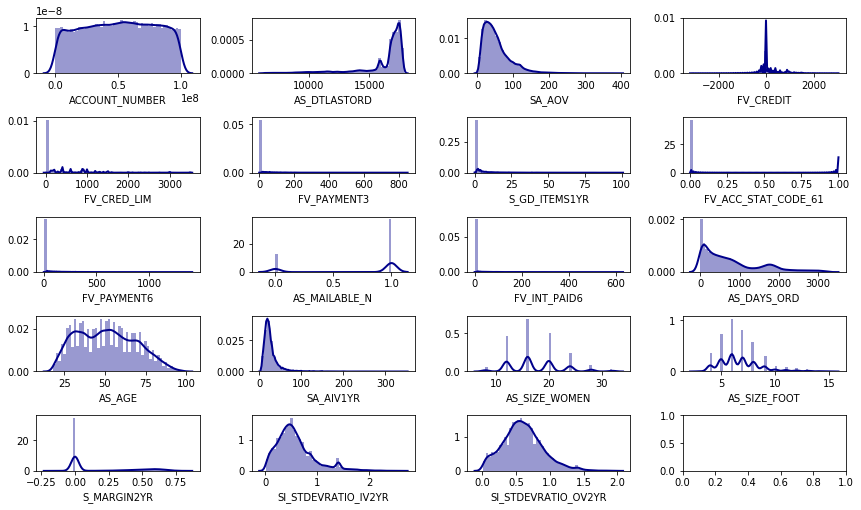

In [13]:
# Plot histograms in a grid.
# (Ignore any MatplotlibDeprecationWarning.)

# Assuming the screen is wide enough to fit around 4 columns of plots side by side, set the number of rows accordingly.
n_col = 4
n_row = int(np.ceil(len(numeric_colnames) / n_col))

fix, axes = plt.subplots(n_row, n_col, figsize=(12, 7))

# Using our custom wrapper for sns.distplot().
for i, colname in enumerate(numeric_colnames):
    srs = mvb_df[colname][~np.isnan(mvb_df[colname])]
    distplot_custom(srs, ax=axes[i // n_col, i % n_col])

# Using sns.distplot().
# for i, colname in enumerate(numeric_colnames):
#     #print(i, i // (n_row - 1), i % n_col) # Debugging.
#     percentiles = np.nanpercentile(mvb_df[colname], q=[0.5, 99,5]) # nanpercentile(): computes percentiles while ignoring NaN.
#     srs = mvb_df[colname][~np.isnan(mvb_df[colname])]
#     sns.distplot(
#         srs[srs.between(percentiles[0], percentiles[1])],
#         ax=axes[i // n_col, i % n_col],
#         #hist_kws={'suptitle': 'ddd'}
#     )
    
plt.tight_layout(pad=0.4, w_pad=0.7, h_pad=0.8)

## Iris data set.
The data scientist's fruit fly.

In [14]:
iris_df = pd.read_csv('s3://{}'.format(os.path.join(bucket, input_prefix, 'iris.csv')))
print('Shape: {}'.format(iris_df.shape))
iris_df.sample(3)

Shape: (150, 5)


,sepal_length,sepal_width,petal_length,petal_width,species
111,6.4,2.7,5.3,1.9,Iris-virginica
73,6.1,2.8,4.7,1.2,Iris-versicolor
146,6.3,2.5,5.0,1.9,Iris-virginica


### Pair plot (scatter plot matrix).
The data set consists of just four numeric columns and one categorical column (species). We can plot all pairwise joint distributions of the numeric columns in the same compact plot.

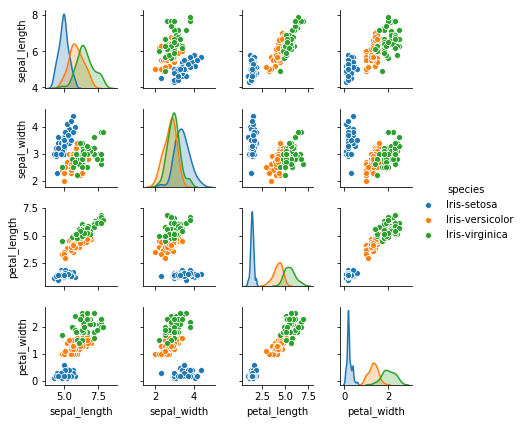

In [15]:
sns.pairplot(
    data=iris_df,
    hue='species',
    #size=1.5 # Deprecated.
    height=1.5
)

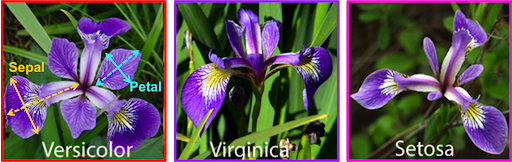

In [16]:
Image(filename='/home/ec2-user/SageMaker/training_repo/images/iris.png')

## Human weights and heights data set.
Source: [kaggle.com/mustafaali96/weight-height](https://www.kaggle.com/mustafaali96/weight-height).

In [17]:
wts_hts_df = pd.read_csv('s3://{}'.format(os.path.join(bucket, input_prefix, 'weight_height.csv')))
print('Shape: {}'.format(wts_hts_df.shape))
wts_hts_df.sample(3)

Shape: (10000, 3)


,Gender,Height,Weight
4071,Male,67.964469,173.911384
7091,Female,65.615612,123.498256
8859,Female,59.986495,129.417764


### Scatter plot with linear fit.

`sns.lmplot()` allows us to generate multiple scatter plots between two given variables of a data set, subsetted by the value of a third variable. Each subset also has an OLS regression line fitted, including confidence intervals. This function is handy if we suspect one or more overlapping overlapping linear relationships, and we want to visualise them quickly.

From the docstring: _"It \[lmplot\] is intended as a convenient interface to fit regression models across conditional subsets of a dataset."_

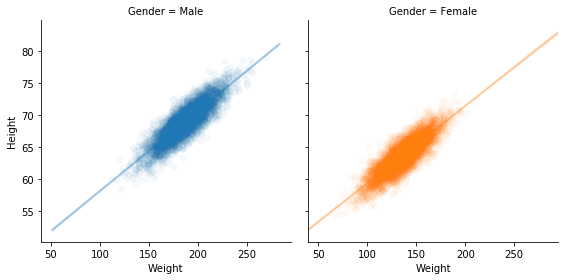

In [18]:
sns.lmplot(
    x='Weight', y='Height',
    col="Gender", # Comment out this line if you want to see both series plotted on the same axes.
    hue='Gender',
    data=wts_hts_df,
    line_kws={'alpha': 0.3}, scatter_kws={'alpha': 0.03},
    #size=4 # Deprecated.
    height=4
)

We can see that weight and height bear a highly linear relationship to one another.

<br>

### Joint plot: scatter + univariate histograms.
Compactly plot both the joint distribution of two variables and the histogram of each on the same chart.

__Male and Female together.__

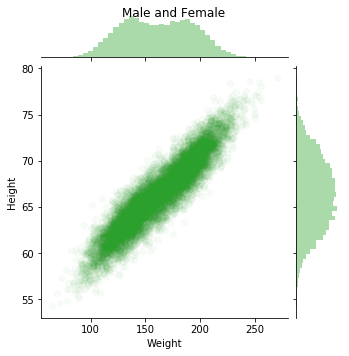

In [19]:
sns.jointplot(
    x='Weight', y='Height',
    data=wts_hts_df, # Plot both male and female together.
    #size=5, # Deprecated
    height=5,
    color=list(sns.color_palette())[2], # Colour = a new colour to distinguish Male and Female individually from Male and Female together.
    joint_kws={'alpha': 0.03}
)
plt.suptitle('Male and Female')
plt.show()

The weight histogram does not look perfectly normal/Gaussian--in fact, it looks double-peaked (bimodal). Let's see if we can separate this into two distributions. Gender is a sensible category to try a split.

__Male.__

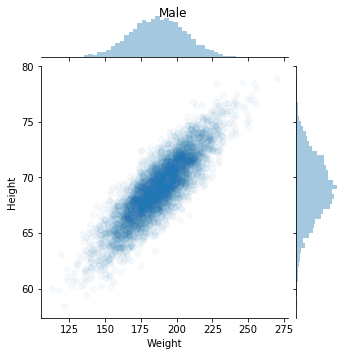

__Female.__

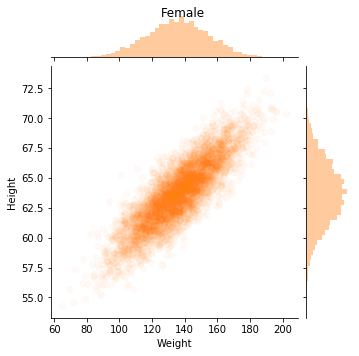

In [20]:
display(md('__Male.__'))
sns.jointplot(
    x='Weight', y='Height',
    data=wts_hts_df[wts_hts_df['Gender'] == 'Male'],
    #size=5, # Deprecated
    height=5,
    color=list(sns.color_palette())[0], # Colour = the particular blue used for Gender = Male above. Just for visual consistency.
    joint_kws={'alpha': 0.03}
)
plt.suptitle('Male')
plt.show()


display(md('__Female.__'))
sns.jointplot(
    x='Weight', y='Height',
    data=wts_hts_df[wts_hts_df['Gender'] == 'Female'],
    #size=5, # Deprecated
    height=5,
    color=list(sns.color_palette())[1], # Colour = the particular orange used for Gender = Female above. Just for visual consistency.
    joint_kws={'alpha': 0.03}
)
plt.suptitle('Female')
plt.show()

<br>

---

<br>

# Summary statistics.
<a id='h1_summary_stats'></a>

## Quick summary statistics with `describe()`.

`df['colname'].describe()` will bring up basic statistics for a single numeric or string column of a dataframe. The statistics reported are different depending on whether the column is numeric or string type. (See `df.types()`.)

In [21]:
mvb_df[['TRADING_CODE']].describe()

,TRADING_CODE
count,100000
unique,25
top,A
freq,7233


<br>

If `describe()` is applied to multiple columns of a dataframe (`df[['col1', 'col2']].describe()`, or to the entire dataframe (`df.describe()`), all __numeric__ columns are summarised. If there are no numeric columns, all __string__ columns are summarised.

In [22]:
mvb_df.describe()

,ACCOUNT_NUMBER,AS_DTLASTORD,SA_AOV,FV_CREDIT,FV_CRED_LIM,FV_PAYMENT3,S_GD_ITEMS1YR,FV_ACC_STAT_CODE_61,FV_PAYMENT6,AS_MAILABLE_N,FV_INT_PAID6,AS_DAYS_ORD,AS_AGE,SA_AIV1YR,AS_SIZE_WOMEN,AS_SIZE_FOOT,S_MARGIN2YR,SI_STDEVRATIO_IV2YR,SI_STDEVRATIO_OV2YR
count,1.000000e+05,99999.000000,73892.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,59247.000000,92836.000000,22593.000000,26770.000000,18654.000000,100000.000000,23871.000000,17605.000000
mean,5.056175e+07,16175.232832,54.837365,97.331116,247.528830,10.702711,2.333250,0.064440,21.004589,0.742790,8.234544,801.348220,51.005720,27.343570,17.550990,6.747186,0.180663,0.583529,0.604590
std,2.835660e+07,2166.737025,42.702675,584.366688,539.684685,71.109262,9.034312,0.245536,113.161714,0.437098,49.415759,763.235282,17.787287,27.498461,4.958383,1.958856,0.261553,0.376346,0.300657
min,2.540000e+03,2571.000000,0.500000,-5418.640000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,0.750000,8.000000,1.000000,-3.670000,0.010000,0.010000
25%,2.665322e+07,15968.500000,27.200000,-50.590000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,187.000000,36.000000,15.980000,12.000000,5.000000,0.000000,0.340000,0.410000
50%,5.111420e+07,17021.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,560.000000,50.000000,21.820000,16.000000,6.000000,0.000000,0.510000,0.580000
75%,7.476225e+07,17412.000000,70.000000,175.000000,200.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1200.000000,65.000000,30.000000,20.000000,8.000000,0.460000,0.730000,0.780000
max,9.999907e+07,17844.000000,2120.450000,3597.370000,3500.000000,3836.480000,300.000000,1.000000,4412.750000,1.000000,985.130000,3357.000000,118.000000,999.000000,36.000000,16.000000,1.000000,4.110000,2.880000


## Summary statistics by group.
With pandas >= 0.25.0, there is a tidy syntax for computing summary statistics by group with `groupby()` and `agg()`.

<br>

__Group the mvb_df dataframe by customer age ("AS_AGE"), and return the mean and median of the customer's average order value ("SA_AOV"). Plot both metrics together.__

In [23]:
aov_mean_sd = mvb_df.groupby('AS_AGE').agg( # To group by multiple columns, we would pass them as a list to groupby(), e.g. ['AS_AGE', 'AS_TTC'].
    SA_AOV_mean=('SA_AOV', 'mean'),
    SA_AOV_median=('SA_AOV', 'median'),
    
    # We could continue adding columns and aggregate functions here.
    #SA_AIV1YR_mean=('SA_AIV1YR', 'mean'),
    #SA_AIV1YR_median=('SA_AIV1YR', 'median')
)
aov_mean_sd.head(3)

,SA_AOV_mean,SA_AOV_median
AS_AGE,,
18.0,35.835500,22.50
19.0,34.905435,26.19
20.0,52.515053,30.92


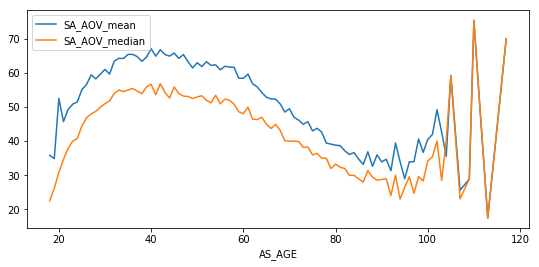

In [24]:
# Quick plot.
plt.figure(figsize=(9, 4))
for col_name, col_data in aov_mean_sd.iteritems():
    col_mask = ~np.isnan(aov_mean_sd['SA_AOV_mean']) # An error will be thrown if we attempt to plot NaN.
    plt.plot(
        pd.Series(aov_mean_sd.index[col_mask]),
        aov_mean_sd[col_name][col_mask]
    )
plt.xlabel(aov_mean_sd.index.name)
plt.legend(loc='best')
plt.show()

`pd.DataFrame.agg()` supports both built-in and custom aggregate functions. The built-in functions can be passed by string, as above, e.g. 'mean', 'median', 'count'. Further built-in aggregate functions are listed below.

| Function | Description |
|----------|-------------------------------------|
| count | Number of non-null observations |
| sum | Sum of values |
| mean | Mean of values |
| mad | Mean absolute deviation |
| median | Arithmetic median of values |
| min | Minimum |
| max | Maximum |
| mode | Mode |
| abs | Absolute Value |
| prod | Product of values |
| std | Unbiased standard deviation |
| var | Unbiased variance |
| sem | Unbiased standard error of the mean |
| skew | Unbiased skewness (3rd moment) |
| kurt | Unbiased kurtosis (4th moment) |
| quantile | Sample quantile (value at %) |
| cumsum | Cumulative sum |
| cumprod | Cumulative product |
| cummax | Cumulative maximum |
| cummin | Cumulative minimum |

<font style="font-size:20px">Exercise</font>

In [25]:
bgc('#D7FFBD')

# Scroll up a few cells to the definition of aov_mean_sd ("aov_mean_sd = mvb_df.groupby('AS_AGE').agg(...".

# Within agg(), add another summary statistic of your choice from the above list, then re-run the cell.

## Custom summary statistics.

As mentioned, `agg()` also supports custom aggregate functions. A custom aggregate function is passed to `agg()` in exactly the same way as a built-in function (only without the quotes).

<font style="font-size:20px">Exercise</font>

__Write two aggregate functions of your own.__

Make sure a scalar is returned. Consider using some functions from numpy, such as `np.mean()`, `np.sin()`, `np.sqrt()`.

In [26]:
bgc('#D7FFBD')
def my_agg_fn_1(srs: pd.Series) -> float:
    '''A custom aggregate function, which takes a pandas Series as input, and returns a scalar.'''
    srs = srs[~np.isnan(srs)] # Remove NaN.
    return 0

In [27]:
bgc('#D7FFBD')
def my_agg_fn_2(srs: pd.Series) -> float:
    '''A custom aggregate function, which takes a pandas Series as input, and returns a scalar.'''
    srs = srs[~np.isnan(srs)] # Remove NaN.
    return 0

### Try out your new aggregate functions.

In [28]:
aov_custom = mvb_df.groupby('AS_AGE').agg( # To group by multiple columns, we would pass them as a list to groupby(), e.g. ['AS_AGE', 'AS_TTC'].
    SA_AOV_count=('SA_AOV', 'count'),
    SA_AOV_myagg1=('SA_AOV', my_agg_fn_1),
    SA_AOV_myagg2=('SA_AOV', my_agg_fn_2)
)
aov_custom.head(10)

,SA_AOV_count,SA_AOV_myagg1,SA_AOV_myagg2
AS_AGE,,,
18.0,40,0.0,0.0
19.0,138,0.0,0.0
20.0,190,0.0,0.0
21.0,230,0.0,0.0
22.0,272,0.0,0.0
23.0,369,0.0,0.0
24.0,443,0.0,0.0
25.0,502,0.0,0.0
26.0,586,0.0,0.0


# Testing for normality.
<a id='h1_normality'></a>
A normality test is a test of goodness-of-fit of a normal distribution to a set of observations.

Some common situations where we might consider running a test for normality:

* Some statistical tests assume that error on each input variable follows a normal distribution; these tests may return slightly (or greatly) skewed output otherwise. Examples include ANOVA, _t_-test, _R_².
* Before using a variable in least-squares regression.
* Analysis of residuals.

## Q-Q plot.
A quantile-quantile plot allows for a visual inspection of normality by plotting the quantiles of the test variable against the quantiles of the normal distribution. A straight line indicates perfect normality.

Q-Q plots are not limited to just the normal distribution.

<br>

Let's write a function to plot a density plot and a Q-Q plot side by side. This will help keep the screen space tidy in a moment.

In [29]:
def plot_density_qq(srs: pd.Series, title: str=''):
    '''A quick ad-hoc function to plot a density plot and a Q-Q plot side by side.'''
    if title == '':
        title = srs.name
    
    fix, axes = plt.subplots(1, 2, figsize=(12, 3))

    plt.subplot(121) # A 1-row × 2-column array of subplots; plot at position 1.
    #sns.distplot(srs[~np.isnan(srs)])
    distplot_custom(srs[~np.isnan(srs)]) # The wrapper for sns.distplot() that we wrote earlier.
    plt.title('Density: {}'.format(title))

    plt.subplot(122) # A 1-row × 2-column array of subplots; plot at position 2.
    probplot(
        srs,
        dist='norm',
        plot=plt
    )
    plt.title('Q-Q plot: {}'.format(title))

    display(md('__{}: density and Q-Q plots.__'.format(srs.name)))
    plt.show()

Let's see if the column "SA_AOV" from the mvb_df dataframe is normally distributed.

__SA_AOV: density and Q-Q plots.__

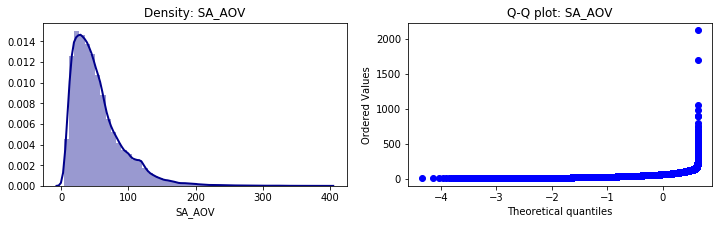

In [30]:
plot_density_qq(mvb_df['SA_AOV'])

We see that the variable, "SA_AOV", (average order value) does not closely follow a normal distribution.

<br>

<font style="font-size:20px">Exercise</font>

__Call `plot_density_qq()` on a column from mvb_df that you predict will be distributed more normally than "SA_AOV".__

In [31]:
mvb_df.columns

Index(['ACCOUNT_NUMBER', 'TRADING_CODE', 'AS_TTC', 'AS_GENDER', 'AS_DTLASTORD',
       'SA_AOV', 'FV_CREDIT', 'FV_CRED_LIM', 'FV_PAYMENT3', 'S_GD_ITEMS1YR',
       'FV_ACC_STAT_CODE_61', 'FV_PAYMENT6', 'AS_MAILABLE_N', 'FV_INT_PAID6',
       'AS_DAYS_ORD', 'AS_AGE', 'SA_AIV1YR', 'AS_SIZE_WOMEN', 'AS_SIZE_FOOT',
       'S_MARGIN2YR', 'SI_STDEVRATIO_IV2YR', 'SI_STDEVRATIO_OV2YR'],
      dtype='object')

In [32]:
bgc('#D7FFBD')

#plot_density_qq(mvb_df['...'])



__Call `plot_density_qq()` on the "Weight" column from the wts_hts_df dataframe.__

__Weight: density and Q-Q plots.__

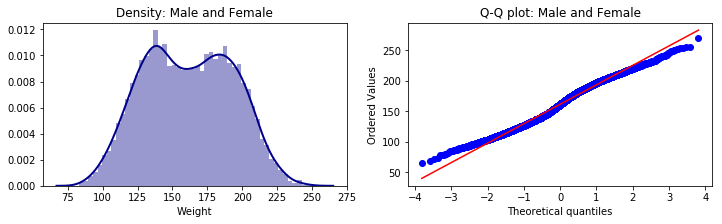

In [33]:
plot_density_qq(wts_hts_df['Weight'], title='Male and Female')

__Call `plot_density_qq()` on the "Weight" column from the wts_hts_df dataframe for Gender = Male and Gender = Female separately.__

__Weight: density and Q-Q plots.__

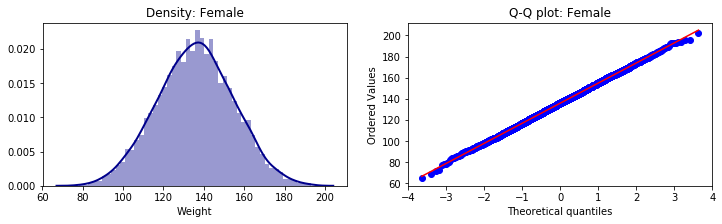

__Weight: density and Q-Q plots.__

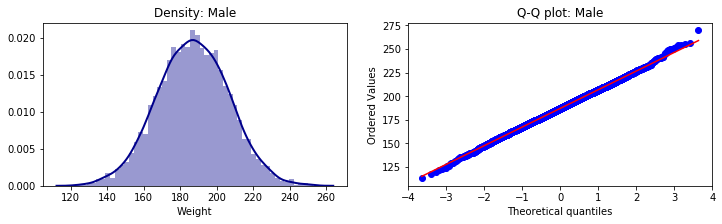

In [34]:
plot_density_qq(wts_hts_df.loc[wts_hts_df['Gender'] == 'Female', 'Weight'], title='Female')
plot_density_qq(wts_hts_df.loc[wts_hts_df['Gender'] == 'Male', 'Weight'], title='Male')

We see that, in the wts_hts_df data set, the distribution of weights of females is highly normal, as is the distribution of weights of males. However, if we blend these two data sets together, the Q-Q plot of the combined data set shows systematic departure from normality.

# Measures of correlation.
<a id='h1_correlation'></a>

Key functions: `spearmanr()`, `pearsonr()`, `kendalltau()` from scipy.stats.

N.B. Pearson correlation assumes that the underlying bivariate relationship is linear, and is a measure of the strength of such. Spearman's rank and Kendall's tau make no assumption of linearity, and are measures of ordinal correlation only.

More information: [statisticssolutions.com/correlation-pearson-kendall-spearman/](https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/).

<font style="font-size:20px">Exercise</font>

__Using `spearmanr()`, compute the Spearman correlation between columns "AS_SIZE_FOOT" and "AS_SIZE_WOMEN" from the mvb_df dataframe.__

(We will choose to omit NaN here, but beware bias when doing that in general.)

In [35]:
bgc('#D7FFBD')

#corr_spear = spearmanr(..., nan_policy='omit'))



## Compute all pairwise correlations.
Here's a code snippet for applying a function between all pairs of columns in a dataframe (from some helpful individual on stackoverflow). We will use it to apply `pearsonr()` between all pairs of numeric columns in the __iris_df__ dataframe.

Source: [stackoverflow.com/questions/33997753/calculating-pairwise-correlation-among-all-columns.](https://stackoverflow.com/questions/33997753/calculating-pairwise-correlation-among-all-columns).

<br>

__Compute the Pearson correlation coefficient between all pairs of numeric columns in the dataframe, iris_df.__

(Note: we'll be fine using iris, but computing the correlations can take a long time on large dataframes with lots of columns. Also, the Kendall tau coefficient is expensive to calculate if you're using that one.)

In [36]:
correlations = {}
numeric_colnames = iris_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_colnames

for col_1, col_2 in itertools.combinations(numeric_colnames, 2):
    correlations[col_1 + '___' + col_2] = pearsonr(iris_df.loc[:, col_1], iris_df.loc[:, col_2])

pairwise_corr_df = pd.DataFrame.from_dict(correlations, orient='index')
pairwise_corr_df.columns = ['Pearson', 'p-value']

display(pairwise_corr_df.sort_index())

,Pearson,p-value
petal_length___petal_width,0.962757,5.776661e-86
sepal_length___petal_length,0.871754,1.038454e-47
sepal_length___petal_width,0.817954,2.314849e-37
sepal_length___sepal_width,-0.109369,1.827652e-01
sepal_width___petal_length,-0.420516,8.429366e-08
sepal_width___petal_width,-0.356544,7.523891e-06


# Regression.
<a id='h1_regression'></a>

## Synthetic data set.
We'll run a trial linear regression on some noisy synthetic data for which we already know the true gradient and intercept.

The _y_-data were generated from the formula $y = a + bx + \epsilon$, where $a = -20$, $b = 3$, and $\epsilon \sim \mathcal{N}(0, 16)$.

In [37]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y = [-21.2, -21.8, -13.5, -11.2, -8.9, -8.8, -4.3, 6, 1.8, 15.9, 11, 13, 15.4, 18.6, 14.3, 19.2, 22.3, 30.4, 37.8, 42.6, 44.7]

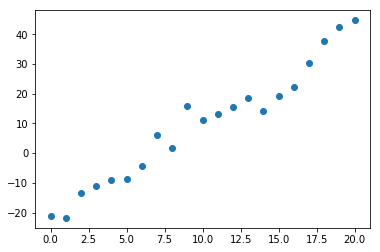

In [38]:
plt.scatter(x, y)
plt.show()

### Fit linear model.
There are lots of packages that can perform ordinary least-squares regression, such as `np.polyfit()` and `LinearRegression` from scikit-learn. Here, we'll look at the offering from `statsmodels`, which can generate a reasonably good summary statistics table.

__First, create a simple wrapper for `statsmodels.api.OLS()`.__

`statsmodels` is great, but the `OLS()` function requires us to create a dummy column of ones in order to fit the intercept coefficient. Since this is slightly awkward, let's handle this in a wrapper function and never worry about it again.

In [39]:
def ols_simple(x, y):
    '''A very simple wrapper around statsmodels.api.OLS() to save us the bother of creating an intercept column filled with ones.'''
    # Add the intercept column (a vector of ones).
    x = sm.add_constant(np.array(x).ravel()) # import statsmodels.api as sm.
    return OLS(y, x, hasconst=True).fit() # from statsmodels.api import OLS.

Now we can apply `ols_simple()` to our synthetic data set. (The coefficients used to generate the data set were $a = -20$, $b = 3$.)

In [40]:
ols_simple(x, y).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     424.4
Date:                Tue, 25 Feb 2020   Prob (F-statistic):           1.86e-14
Time:                        12:00:14   Log-Likelihood:                -58.909
No. Observations:                  21   AIC:                             121.8
Df Residuals:                      19   BIC:                             123.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.5385      1.772    -12.158      0.000     -25.246     -17.831
x1             3.1219      0.152     20.602      0.000       2.805       3.439
==============================================================================
Omnibus:                        0.519   Durbin-Watson:                   1.340
Prob(Omnibus):                  0.771   Jarque-Bera (JB):                0.073
Skew:                           0.143   Prob(JB):                        0.964
Kurtosis:                       3.040   Cond. No.                         22.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

And now we are quite happy because we see that $\textrm{const} =-21.5 \pm 1.7$, and $x_1 = 3.1 \pm 0.2$, both of which comfortably overlap with the true parameter values of –20 and 3.

We can also call `print()` on the output table to display as plaintext.

In [41]:
print(ols_simple(x, y).summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     424.4
Date:                Tue, 25 Feb 2020   Prob (F-statistic):           1.86e-14
Time:                        12:00:14   Log-Likelihood:                -58.909
No. Observations:                  21   AIC:                             121.8
Df Residuals:                      19   BIC:                             123.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.5385      1.772    -12.158      0.0

## Bootstrapped linear regression.
We'll use `np.random.choice()` with replacement to draw bootstrap samples in a loop. Linear regression is then run on each sample, and the coefficients added to a list.

In [42]:
n_boot = 10000
lm_bs = []

for i in range(0, n_boot):
    boot_inds = list(np.random.choice(range(0, len(x)), size=len(x), replace=True))
    lm_bs.append(
        ols_simple(
            [x[boot_inds[i]] for i in boot_inds],
            [y[boot_inds[i]] for i in boot_inds]
        ).params
    )

Sanity-check the bootstrapped coefficients. We expect the columns to be (~ -20, ~ 3).

In [43]:
lm_bs[0:5]

[array([-22.65889825,   3.19080492]),
 array([-22.78147139,   3.14551647]),
 array([-22.65873757,   3.35183836]),
 array([-22.30384615,   3.26730769]),
 array([-24.2486132 ,   3.27395184])]

We can use the nifty "\*" operator with `zip()` to reshape the list of _n_ _m_-tuples (/arrays) into _m_ _n_-tuples ("columns") and compute summary statistics on each, regardless of _m_.

In [44]:
[(np.mean(beta), np.std(beta)) for beta in zip(*lm_bs)]
# Source: https://www.geeksforgeeks.org/python-position-summation-in-list-of-tuples/.

[(-21.334444906236314, 2.0705372280721734),
 (3.0987620485392777, 0.20301526893687694)]

We see that the bootstrapped regression coefficients are comfortably within error of the true coefficient values of -20 and 3.

The bootstrapped standard error on each coefficient is also broadly in line with that found by non-bootstrapped OLS.

# Resampling.
<a id='h1_resampling'></a>

If we have the luxury of access to the parent population from which our sample was drawn, we can perform resampling instead of bootstrapping. Here, we are sampling fresh random numbers, _y_, from the distribution that created the particular sample of _y_ that we used above.

In [45]:
n_resamp = 10000
lm_resamp = []

for i in range(0, n_resamp):
    y_resamp = -20.0 + 3.0 * np.array(x) + np.random.normal(0, 4, len(x))
    lm_resamp.append(
        ols_simple(
            x,
            y_resamp
        ).params
    )

In [46]:
lm_resamp[0:5]

[array([-22.08859052,   3.13563549]),
 array([-19.39188684,   2.93016092]),
 array([-20.53760373,   2.98890046]),
 array([-17.93156069,   2.89155347]),
 array([-21.61079121,   3.14573547])]

In [47]:
[(np.mean(beta), np.std(beta), np.std(beta) / np.sqrt(len(lm_resamp))) for beta in zip(*lm_resamp)]

[(-19.999724666404862, 1.6633999526783685, 0.016633999526783686),
 (3.000438325594652, 0.14299233550813334, 0.0014299233550813333)]

We can see that 10 k rounds of resampling has produced more accurate (although not much more _precise_) coefficients--they are much close to the true values of –20 and 3.

In this case, since we happen to know that there is zero systematic error on the resampled (and normal, iid) _y_ values, it is valid to take the standard error on the mean as an unbiased estimator of the error on each coefficient. With bootstrapping, we couldn't do that, since we cannot know the systematic bias present in a single sample of _y_.

# Optimisation.
<a id='h1_optimisation'></a>

Here's a brief example of multidimensional optimistion using `fmin()` from scipy.optimize.

You could change `my_loss_fn()` to any function you want to minimise. Here, we will vary coefficient array beta to minimise the sum of squared difference between y and beta * x. We would expect to see beta converge to the same values as those found by ordinary least-squares regression.

In [48]:
def my_loss_fn_1(beta, x: np.array, y: np.array):
    return sum(((beta[0] + beta[1] * x) - y) * ((beta[0] + beta[1] * x) - y))

In [49]:
fmin(my_loss_fn_1, x0=[0, 0], args=(np.array(x), np.array(y))) # x0 is the vector of initial guesses for the beta coefficients. Beware non-convex loss functions.

Optimization terminated successfully.
         Current function value: 335.961459
         Iterations: 86
         Function evaluations: 165


array([-21.53856312,   3.12194881])

We see that the values converged upon are the same as the coefficients found by OLS regression earlier: -21.5385 and 3.1219.

# Sampling from random distributions.
<a id='h1_rand_samp'></a>

Many common applications. Examples:

* Sampling elements from arrays.
* Deliberately adding noise, e.g. to test the robustness of a model.
* Monte Carlo simulation.
* Bootstrapping.
* Generating synthetic data.

## Sampling from the uniform distribution.

### Generate a random integer.

> `np.random.randint(low, high=None, size=None, dtype='l')`

> _"Return a random integer N such that a <= N <= b. Alias for randrange(a, b+1)."_

> __Returns:__ int or ndarray of ints.

[Documentation](https://docs.python.org/3/library/random.html#random.randint).

Note: the lower bound, `low`, is inclusive, while the upper bound, `high`, is exclusive. `high` also gets rounded __towards zero__ to the nearest integer. So we must set the upper bound to 6 in order for the true upper integer bound to be 5.

<br>

__Generate 1 random integer between 0 and 5 from the uniform distribution.__

In [50]:
np.random.randint(0, 6)           # Generate a random integer between 0 and 5 (not 6).

#np.random.randint(0, 5.999)      # The 5.999 gets rounded down to 5. This will thus generate a random integer between 0 and 4.
#np.random.randint(0.999, 5.999)  # This would also return an integer between 0 and 4.

3

If we pass only a single argument to `randint()`, this becomes the `high` parameter, and the `low` parameter is implicitly 0. This only works if the argument is ≥ 1.

In [51]:
np.random.randint(2)   # Generate a random integer between 0 and 1.

#np.random.randint(1)  # This would always return 0.
#np.random.randint(0)  # This would throw an error: "low >= high".

1

<br>

__Generate a random integer between -10 and -8 from the uniform distribution.__

In [52]:
np.random.randint(-10, -7)

-9

### Generate a random floating-point number.

> `np.random.uniform(low=0.0, high=1.0, size=None)`

> _"Return a random floating point number N such that a <= N <= b."_

> __Returns:__ ndarray or scalar.

[Documentation](https://docs.python.org/3/library/random.html#random.uniform).

---

The function `np.random.uniform()` works very similarly to `np.random.randint()`.

<br>

__Generate 1 random floating-point number between -0.5 and 0.5 from the uniform distribution.__

In [53]:
np.random.uniform(-0.5, 0.5)

-0.3112368405984456

### Generate multiple random numbers.

Both `np.random.randint()` and have a `size` parameter, which specifies how many random numbers to return. Return type is np.ndarray.

<font style="font-size:20px">Exercise</font>

__Generate a numpy array of 50 random binary integers (0 or 1).__

In [54]:
bgc('#D7FFBD')




<font style="font-size:20px">Exercise</font>

__Generate a numpy array of 20 random floating-point numbers between -0.5 and 0.5 from the uniform distribution.__

In [55]:
bgc('#D7FFBD')




## Sampling from the normal a.k.a. Gaussian distribution.

> `np.random.gauss(loc=0.0, scale=1.0, size=None)`

> _"Draw random samples from a normal (Gaussian) distribution."_

> __Returns:__ ndarray or scalar.

[Documentation](https://docs.scipy.org/doc/numpy-1.14.5/reference/generated/numpy.random.normal.html#numpy.random.normal).

---

The `loc` and `scale` parameters correspond to the $\mu$ (mean) and $\sigma$ (standard deviation) parameters of the normal distribution. As before, `size` is the number of samples to draw.

<br>

__Generate a numpy array of 10 random numbers from the normal distribution with parameters $\mu = 0$, $\sigma = 1$.__

In [56]:
np.random.normal(0, 1, size=10)

array([ 0.23804299, -0.69302142, -0.13612209,  0.98184264,  0.40778818,
       -0.51297967,  0.32354093,  0.50565334, -0.70267584,  1.11139487])

## Sampling from other distributions.

### Binomial distribution.

__Generate a numpy array of 10 random numbers from the binomial distribution with parameters $n = 100$, $p = 0.2$.__

In [57]:
np.random.binomial(n=100, p=0.2, size=10)

array([19, 21, 27, 17, 18, 27, 15, 29, 22, 19])

<font style="font-size:20px">Exercise</font>

__Simulate flipping a coin 10,000 times using `np.random.binomial()`. How many heads did you get?__

In [58]:
bgc('#D7FFBD')




<font style="font-size:20px">Exercise</font>

__Now simulate 1000 runs of flipping a coin 10,000 times and store the results in an array called coin_10k. What are the mean and standard deviation of coin_10k?__

_Maths nerd cred:_ Before you start, what do you predict the standard deviation will be?

In [59]:
bgc('#FFD95F')




### Poisson distribution.

__Generate a numpy array of 20 random numbers from the Poisson distribution with $\lambda = 1.5$.__

In [60]:
np.random.poisson(lam=1.5, size=20)

array([1, 2, 3, 2, 3, 3, 1, 1, 2, 2, 2, 0, 1, 1, 1, 4, 3, 2, 3, 4])

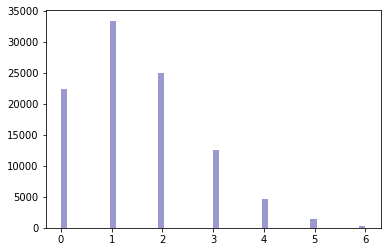

In [61]:
distplot_custom(pd.Series(np.random.poisson(lam=1.5, size=100000)), kde=False)

### Exponential distribution.

__Generate a numpy array of 20 random numbers from the exponential distribution with $\lambda = 1.5$.__

In [62]:
np.random.exponential(scale=1.0, size=20)

array([0.94113523, 0.53782241, 1.27285353, 0.36793623, 1.24567061,
       0.27286403, 0.66310683, 0.61560678, 0.23292073, 1.76265441,
       1.57625538, 4.29740626, 5.51731335, 4.94402317, 1.98971481,
       0.09110942, 0.03615744, 0.1106459 , 0.47905654, 0.38302769])

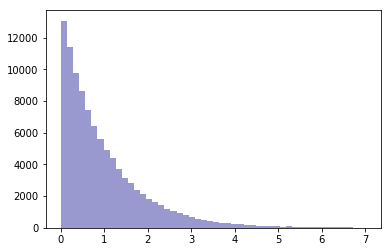

In [63]:
distplot_custom(pd.Series(np.random.exponential(scale=1.0, size=100000)), kde=False)

# Standard deviation.
<a id='h1_std_dev'></a>

## Population standard deviation.
numpy has a function, `np.std()`, which computes the standard devation.

However, by default, `np.std()` returns the __population__ standard deviation, whereas what we usually want is the __sample__ standard deviation.

To get `np.std()` to return the sample standard deviation, we can set the `ddof` ("delta degrees of freedom") parameter to 1 (default 0).

In [64]:
x_sd_pop = np.std(x)
x_sd_samp = np.std(x, ddof=1)

x_sd_pop, x_sd_samp

(6.0553007081949835, 6.2048368229954285)

I'm sure we can trust numpy, but let's just check that we're getting the actual sample standard deviation as commonly defined.

In [65]:
np.sqrt(
    sum((x - np.mean(x)) * (x - np.mean(x)))
    / (len(x) - 1)
)

6.2048368229954285

Oh good, everything is fine.

# Director's cut.
<a id='h1_directors_cut'></a>

Extra stuff that wasn't good enough to make it into the main feature.

## Bias-corrected sample standard deviation.
The sample standard deviation is not a truly unbiased estimator of the standard deviation of the population: it is actually a slight underestimate. The amount of bias is negligible when the sample size is large; however, for small samples (roughly, _N_ < 10) the amount of bias is large enough that we might want to consider correcting for it.

The table shows the amount of underestimation of the sample standard deviation relative to the true standard deviation of the population. For example, for _N_ = 2, the sample std. dev. is only 79.8% that of the true standard deviation of the population.

| N | Sample std. relative to truth |
|----|-------------------------------|
| 2 | 0.797885 |
| 3 | 0.886227 |
| 4 | 0.921318 |
| 5 | 0.939986 |
| 6 | 0.951533 |
| 7 | 0.959369 |
| 8 | 0.96503 |
| 9 | 0.969311 |
| 10 | 0.972659 |

Fortunately, there is an analytic solution for the correction factor.

Unfortunately, it looks like this:

$${\displaystyle c_{4}(N)={\sqrt {\frac {2}{N-1}}}{\frac {\Gamma \left({\frac {N}{2}}\right)}{\Gamma \left({\frac {N-1}{2}}\right)}}=1-{\frac {1}{4N}}-{\frac {7}{32N^{2}}}-{\frac {19}{128N^{3}}}+O(N^{-4})}$$

See: [en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation](https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation).

Fortunately, we can approximate the correction factor to better than 99.7% accuracy with a simple fraction.

$${\displaystyle c_{4}(N) \approx {\frac {N-1}{N-\tfrac {3}{4}}}}$$

In [66]:
x_sd_pop = np.std(x)
x_sd_samp = np.std(x, ddof=1)

print('Std. dev. pop.:                {}'.format(x_sd_pop))
print('Std. dev. samp.:               {}'.format(x_sd_samp))
print('Std. dev. samp (bias corr.).:  {}'.format(x_sd_samp * (len(x) - 0.75) / (len(x) - 1)))

Std. dev. pop.:                6.0553007081949835
Std. dev. samp.:               6.2048368229954285
Std. dev. samp (bias corr.).:  6.282397283282871


### Unbiased sample std. dev. function.

In [67]:
def std_samp(x: float) -> float:
    '''Bias-corrected sample standard deviation.'''
    return np.std(x, ddof=1) * (len(x) - 0.75) / (len(x) - 1)

In [68]:
std_samp(x)

6.282397283282871

## Calculating $\pi$ with random numbers.

<font style="font-size:20px">Tricky exercise</font>

__Pretend the centre of this circle is at coordinates (0, 0). The circle is inscribed in a square of side length 1. We know that the area of the square is 1, and the area of the circle is $\pi \times (0.5)^{2}$, so the ratio of the area of the square to the area of the circle is $\frac {4}{\pi}$.__

__Generate 10 M pairs of random _x_- and _y_-coordinates within the square, sampling from the uniform distribution. I.e. we are choosing random points within the square. What fraction of the points lie within the circle. What is $\pi$?__

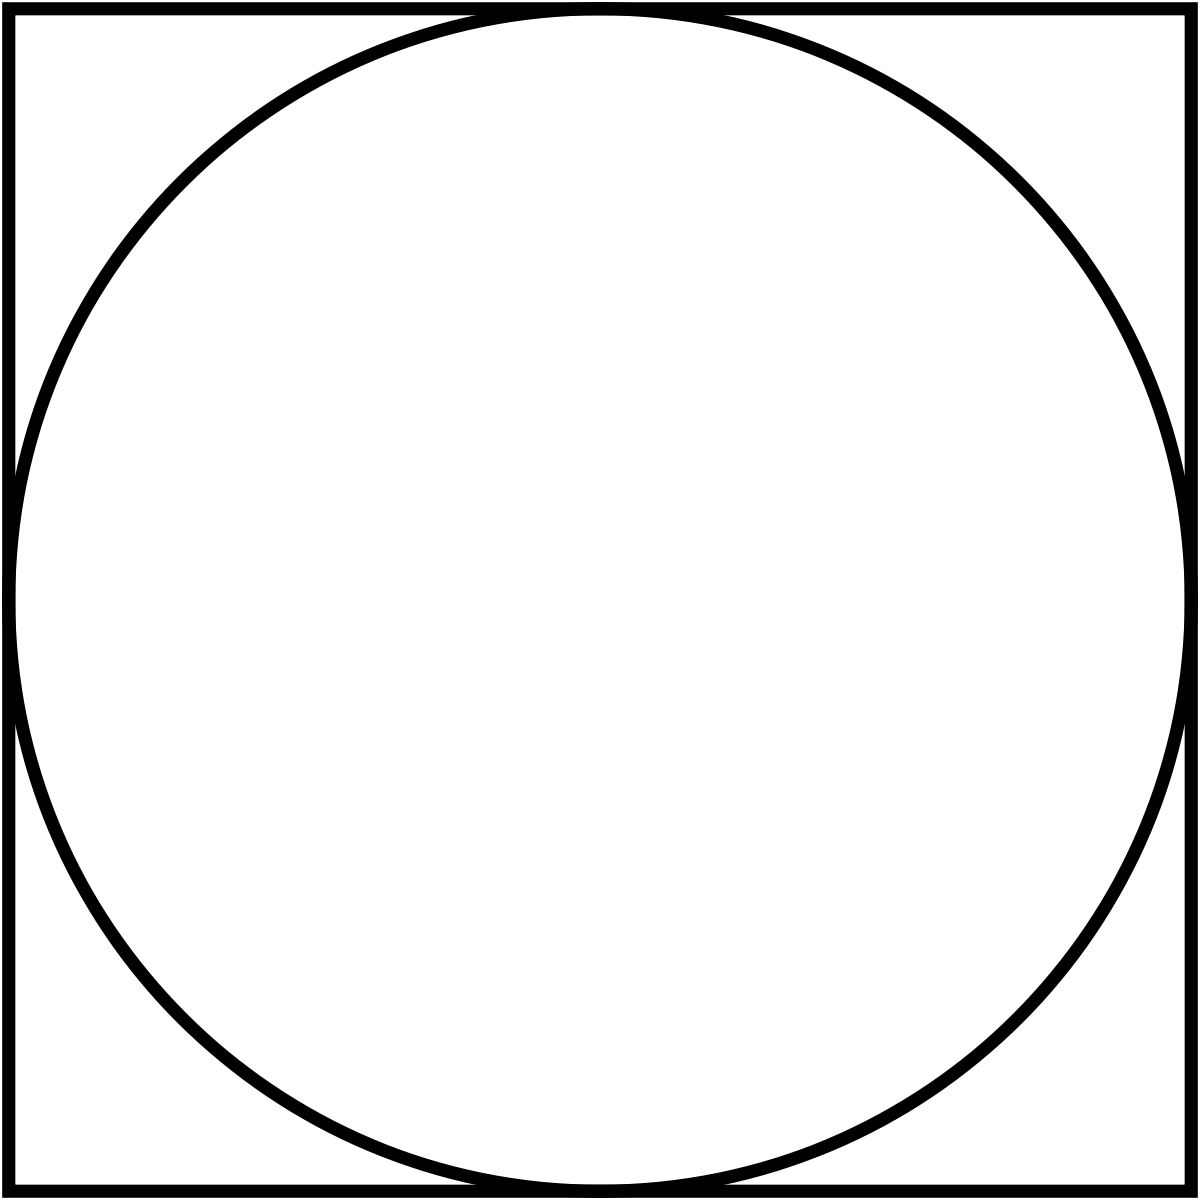

In [69]:
Image(filename='/home/ec2-user/SageMaker/training_repo/images/circle_in_square.png', width=140)

In [70]:
bgc('#FFD95F')


